# Chemical Kinetics: Cantera Basics
This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 4 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 10 February 2020.

The objective of this tutorial is to introduce how to access and manipulate a reaction mechanism using Cantera's `Solution()` object. The modified Arrhenius form of the reaction rate coefficient is discussed, including the use of third-body efficiencies for three-body reactions. A brief discussion of Python dictionary objects is provided. We will use the thermodynamic properties and the reaction mechanism that are included in gri30.cti.

The reader should be familiar with the material in the Chapter 3 Notebooks before working through this Notebook.

## 1. An example of a reaction mechanism: GRI-Mech 3.0

Up to this point, we have worked mainly with thermodynamic properties of individual ideal-gas species and of ideal-gas mixtures using Cantera. Now we will consider the chemical reactions that occur among those species. The *chemical mechanism* or *reaction mechanism* is a list of the allowable chemical reactions, including information about the rates for each reaction. We briefly introduced a few attributes related to chemical reactions in tutorial Notebook 2_7_Entropy_Gibbs_function_equilibrium_constants. Here we will go deeper into the attributes related to chemical reactions, how to use them, and how they relate to the quantitites introduced in Chapter 4 of Turns 4th ed.

To illustrate the various attributes related to chemical reactions, we will consider the reaction mechanism that is provided in gri30.cti. That is the [GRI-Mech 3.0](http://combustion.berkeley.edu/gri-mech/version30/text30.html) mechanism for natural gas, which (looking ahead a bit) is shown in Table 5.4 of Turns 4th ed. This mechanism considers 325 different chemical reactions that involve 53 different chemical species.

In [1]:
# access modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define an ideal-gas mixture named "gas1" using Cantera's "Solution" object and GRI-Mech 3.0
gas1 = ct.Solution('gri30.cti')

In [3]:
# "n_species" and "n_reactions" (which we have seen earlier) are the number of species considered in the gas mixture 
#   and the number of reactions considered in the reaction mechanism, respectively
gas1.n_species , gas1.n_reactions

(53, 325)

This confirms that GRI-Mech 3.0 considers 53 species and 325 reactions.

In [4]:
# list the n_species (=53 here) species in the gas mixture, for future reference
gas1.species()

[<Species H2>,
 <Species H>,
 <Species O>,
 <Species O2>,
 <Species OH>,
 <Species H2O>,
 <Species HO2>,
 <Species H2O2>,
 <Species C>,
 <Species CH>,
 <Species CH2>,
 <Species CH2(S)>,
 <Species CH3>,
 <Species CH4>,
 <Species CO>,
 <Species CO2>,
 <Species HCO>,
 <Species CH2O>,
 <Species CH2OH>,
 <Species CH3O>,
 <Species CH3OH>,
 <Species C2H>,
 <Species C2H2>,
 <Species C2H3>,
 <Species C2H4>,
 <Species C2H5>,
 <Species C2H6>,
 <Species HCCO>,
 <Species CH2CO>,
 <Species HCCOH>,
 <Species N>,
 <Species NH>,
 <Species NH2>,
 <Species NH3>,
 <Species NNH>,
 <Species NO>,
 <Species NO2>,
 <Species N2O>,
 <Species HNO>,
 <Species CN>,
 <Species HCN>,
 <Species H2CN>,
 <Species HCNN>,
 <Species HCNO>,
 <Species HOCN>,
 <Species HNCO>,
 <Species NCO>,
 <Species N2>,
 <Species AR>,
 <Species C3H7>,
 <Species C3H8>,
 <Species CH2CHO>,
 <Species CH3CHO>]

Now let's explore what other reaction-mechanism-related attributes are available. A few of them were introduced earlier, in tutorial Notebook 2_7_Entropy_Gibbs_function_equilibrium_constants:

In [5]:
# display all attributes of gas1
dir(gas1)

['DP',
 'DPX',
 'DPY',
 'HP',
 'HPX',
 'HPY',
 'ID',
 'P',
 'P_sat',
 'SP',
 'SPX',
 'SPY',
 'SV',
 'SVX',
 'SVY',
 'T',
 'TD',
 'TDX',
 'TDY',
 'TP',
 'TPX',
 'TPY',
 'T_sat',
 'UV',
 'UVX',
 'UVY',
 'X',
 'Y',
 '__call__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_check_kinetics_species_index',
 '_check_phase_index',
 '_check_reaction_index',
 '_full_states',
 '_init_cti_xml',
 '_init_parts',
 '_references',
 'activities',
 'activity_coefficients',
 'add_reaction',
 'add_species',
 'atomic_weight',
 'atomic_weights',
 'basis',
 'binary_diff_coeffs',
 'chemical_potentials',
 'concentrations',
 'cp',
 'cp_mass',
 'cp_mole',
 'cr

Scrolling down through the list of available attributes, it can be seen that there are several that appear to be related to chemical reactions. You can use `help()` or `?` to find out more about each attribute. For example:

In [6]:
# verify that "n_reactions" is the number of reactions in the reaction mechanism
help(gas1.__class__.n_reactions)

Help on getset descriptor cantera._cantera.Kinetics.n_reactions:

n_reactions
    Number of reactions in the reaction mechanism.



The `n_reactions` reactions are numbered using a reaction index that ranges from 0 to `n_reactions`-1.

## 2. Reaction equations and reaction types

In this section, we look at the following reaction-related attributes: [`reactions`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.reactions), [`reaction()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.reaction), [`reaction_equations`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.reaction_equations), [`reaction_equation()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.reaction_equation), and [`reaction_type()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.reaction_type).

In [7]:
# the n_reactions chemical reactions in the reaction mechanism can be accessed, along with their reaction types,
#   using "reactions"
help(gas1.__class__.reactions)

Help on method_descriptor:

reactions(...)
    Kinetics.reactions(self)
    
    Return a list of all `Reaction` objects. Changes to these objects do not
    affect the `Kinetics` or `Solution` object until the `modify_reaction`
    function is called.



That is, `reactions` is a list (not a function). In contrast, `reaction()` is a method or function that takes a reaction index as its argument:

In [8]:
# how is "reaction" different from "reactions"?
help(gas1.__class__.reaction)

Help on method_descriptor:

reaction(...)
    Kinetics.reaction(self, int i_reaction)
    
    Return a `Reaction` object representing the reaction with index
    ``i_reaction``. Changes to this object do not affect the `Kinetics` or
    `Solution` object until the `modify_reaction` function is called.



In [9]:
# list the n_reactions (=325 here) reactions in gas1 (i.e., in GRI-Mech 3.0), including their reaction types
gas1.reactions()

[<ThreeBodyReaction: 2 O + M <=> O2 + M>,
 <ThreeBodyReaction: H + O + M <=> OH + M>,
 <ElementaryReaction: H2 + O <=> H + OH>,
 <ElementaryReaction: HO2 + O <=> O2 + OH>,
 <ElementaryReaction: H2O2 + O <=> HO2 + OH>,
 <ElementaryReaction: CH + O <=> CO + H>,
 <ElementaryReaction: CH2 + O <=> H + HCO>,
 <ElementaryReaction: CH2(S) + O <=> CO + H2>,
 <ElementaryReaction: CH2(S) + O <=> H + HCO>,
 <ElementaryReaction: CH3 + O <=> CH2O + H>,
 <ElementaryReaction: CH4 + O <=> CH3 + OH>,
 <FalloffReaction: CO + O (+M) <=> CO2 (+M)>,
 <ElementaryReaction: HCO + O <=> CO + OH>,
 <ElementaryReaction: HCO + O <=> CO2 + H>,
 <ElementaryReaction: CH2O + O <=> HCO + OH>,
 <ElementaryReaction: CH2OH + O <=> CH2O + OH>,
 <ElementaryReaction: CH3O + O <=> CH2O + OH>,
 <ElementaryReaction: CH3OH + O <=> CH2OH + OH>,
 <ElementaryReaction: CH3OH + O <=> CH3O + OH>,
 <ElementaryReaction: C2H + O <=> CH + CO>,
 <ElementaryReaction: C2H2 + O <=> H + HCCO>,
 <ElementaryReaction: C2H2 + O <=> C2H + OH>,
 <El

Comparing this to Table 5.4 in Chapter 5 of Turns 4th ed., it can be seen that the reactions are listed in the same order here as there. There the reactions are indexed from 1 to 325, whereas here they are indexed from 0 to 324. 

In [10]:
# access a single reaction (here, reaction index 0, corresponding to the first reaction in the mechanism),
#   including its reaction type
gas1.reaction(0)

<ThreeBodyReaction: 2 O + M <=> O2 + M>

This is the same as reaction 1 in Table 5.4. However, in Table 5.4 it is not indicated which reactions are reversible and which are irreversible.

At this point, it is appropriate to make a few comments on notation and on reaction types.

In Cantera, a reversible reaction is indicated by <=> or just by =. An irreversible reaction is indicated using a forward arrow: =>. Most of the reactions in the current mechanism are reversible reactions, but by scrolling down in the window above, it can be seen that there are some irreversible reactions.

Several types of reactions can be specified in Cantera. Details can be found at http://cantera.github.io/docs/sphinx/html/cti/reactions.html. Brief descriptions of the three reaction types that are used in the current mechanism follow.

* An *elementary reaction* (ElementaryReaction) is a reaction that represents the outcome of a molecular collision. The reaction order with respect to each species (that is, the power to which that species' molar concentration appears in the rate expression) is equal to the species stoichiometric coefficient. Rate coefficients are given in modified Arrhenius form: a pre-exponential factor, a temperature exponent, and an activation energy are specified for the forward reaction, as we will see below. Then the reverse rate (in the case of a reversible reaction) is computed internally using the equilibrium constant (a thermodynamic quantity) for the reaction. The reaction rate coefficients do not depend explicitly on pressure - the only pressure dependence is through the molar concentrations of the reactants.


* A *three-body reaction* (ThreeBodyReaction), or termolecular reaction, is a special case of an elementary reaction that usually involves an unspecified third collision partner species denoted by "M", where M can be any species in the reaction mechanism. Different species can have different efficiences as collision partners. Therefore, in addition to the usual modified Arrhenius parameters, for a three-body reaction one can specify different efficiencies for each reaction partner M. This is discussed further in Section 6 below. 


* A *fall-off reaction* (FalloffReaction) is a three-body reaction for which the reaction rate is first-order in the molar concentration of M (denoted as [M]) at low pressure (as for a regular three-body reaction) but becomes zero-order in [M] as the pressure increases. Therefore, in addition to the usual modified Arrhenius parameters, additional information must be provided on how the "fall-off" varies with pressure and temperature. The details are beyond the scope of our current introductory level of discussion of reaction kinetics.

For our purposes, elementary reactions (including three-body reactions) and global reactions (for which the reaction orders are empirical, and must be specified separately from the stoichiometric coefficients) are of most interest. There are no global reactions in the current mechanism. Those will be discussed in a subsequent tutorial, when we get to Chapter 5 of Turns 4th ed.

Now, let's continue to look at attributes related to chemical reactions.

In [11]:
# the n_reactions reactions can be accessed, without their reaction types, using "reaction_equations"
help(gas1.__class__.reaction_equations)

Help on method_descriptor:

reaction_equations(...)
    Kinetics.reaction_equations(self, indices=None)
    
    Returns a list containing the reaction equation for all reactions in the
    mechanism (if *indices* is unspecified) or the equations for each
    reaction in the sequence *indices*. For example::
    
        >>> gas.reaction_equations()
        ['2 O + M <=> O2 + M', 'O + H + M <=> OH + M', 'O + H2 <=> H + OH', ...]
        >>> gas.reaction_equations([2,3])
        ['O + H + M <=> OH + M', 'O + H2 <=> H + OH']
    
    See also `reaction_equation`.



Note that `reaction_equations` is a list. What about `reaction_equation()`?

In [12]:
# how is "reaction_equation" different from "reaction_equations"?
help(gas1.__class__.reaction_equation)

Help on method_descriptor:

reaction_equation(...)
    Kinetics.reaction_equation(self, int i_reaction)
    The equation for the specified reaction. See also `reaction_equations`.



So, `reaction_equation()` is a method or function that takes a reaction index as its argument.

In [13]:
# print all n_reactions reactions in the reaction mechanism, without their reaction types
gas1.reaction_equations()

['2 O + M <=> O2 + M',
 'H + O + M <=> OH + M',
 'H2 + O <=> H + OH',
 'HO2 + O <=> O2 + OH',
 'H2O2 + O <=> HO2 + OH',
 'CH + O <=> CO + H',
 'CH2 + O <=> H + HCO',
 'CH2(S) + O <=> CO + H2',
 'CH2(S) + O <=> H + HCO',
 'CH3 + O <=> CH2O + H',
 'CH4 + O <=> CH3 + OH',
 'CO + O (+M) <=> CO2 (+M)',
 'HCO + O <=> CO + OH',
 'HCO + O <=> CO2 + H',
 'CH2O + O <=> HCO + OH',
 'CH2OH + O <=> CH2O + OH',
 'CH3O + O <=> CH2O + OH',
 'CH3OH + O <=> CH2OH + OH',
 'CH3OH + O <=> CH3O + OH',
 'C2H + O <=> CH + CO',
 'C2H2 + O <=> H + HCCO',
 'C2H2 + O <=> C2H + OH',
 'C2H2 + O <=> CH2 + CO',
 'C2H3 + O <=> CH2CO + H',
 'C2H4 + O <=> CH3 + HCO',
 'C2H5 + O <=> CH2O + CH3',
 'C2H6 + O <=> C2H5 + OH',
 'HCCO + O <=> 2 CO + H',
 'CH2CO + O <=> HCCO + OH',
 'CH2CO + O <=> CH2 + CO2',
 'CO + O2 <=> CO2 + O',
 'CH2O + O2 <=> HCO + HO2',
 'H + O2 + M <=> HO2 + M',
 'H + 2 O2 <=> HO2 + O2',
 'H + H2O + O2 <=> H2O + HO2',
 'H + N2 + O2 <=> HO2 + N2',
 'AR + H + O2 <=> AR + HO2',
 'H + O2 <=> O + OH',
 '2 H 

This is the same as the result from `reactions`, but without the reaction types. Note that all of the reactions are either two-body reactions or three-body reactions in both the forward and reverse (in the case of reversible reactions) directions.

In [14]:
# an individual reaction without its reaction type can be accessed using the function "reaction_equation"
# the argument (324 in the example here, corresponding to the last reaction in the mechanism) is the reaction index
gas1.reaction_equation(324)

'C3H7 + CH3 <=> 2 C2H5'

An integer corresponding to the reaction type for each reaction is accessible using the `reaction_type()` attribute, which is a function that takes a reaction index as its argument:

In [15]:
# get help for attribute "reaction_type"
help(gas1.__class__.reaction_type)

Help on method_descriptor:

reaction_type(...)
    Kinetics.reaction_type(self, int i_reaction)
    Type of reaction *i_reaction*.



In [16]:
# reaction type 1 corresponds to ElementaryReaction
# reaction index 2 has this reaction type, for example
gas1.reaction_type(2)

1

In [17]:
# reaction type 2 corresponds to ThreeBodyReaction
# reaction index 0 has this reaction type, for example
gas1.reaction_type(0)

2

In [18]:
# reaction type 4 corresponds to FalloffReaction
# reaction index 11 has this reaction type, for example
gas1.reaction_type(11)

4

Further information about reaction types 1 and 2 is provided below.

## 3. Subsets of reactions

Just as one can work with a subset of the species in the gas mixture, one can work with a subset of the chemical reactions in the reaction mechanism. For example, one can collect the subset of reactions for which CO is on the left-hand side (the reactant side) and CO2 is on the right-hand side (the product side), as follows, where we use the [`reactants()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.reactants) and [`products()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.products) attributes:

In [19]:
CO_to_CO2_reactions = [i for i, r in enumerate(gas1.reactions()) if 'CO' in r.reactants and 'CO2' in r.products]

for i in CO_to_CO2_reactions:
    print(gas1.reaction(i).equation)

CO + O (+M) <=> CO2 (+M)
CO + O2 <=> CO2 + O
CO + OH <=> CO2 + H
CO + HO2 <=> CO2 + OH


There are four reactions in the current reaction mechanism that have CO on the left-hand (reactants) side and CO2 on the right-hand (products) side.

We will work with subsets of reactions in subsequent tutorials.

## 4. Reactants, products, and stoichiometric coefficients

As suggested by the example in Section 3 above, the left-hand-side of a reaction is accessible using attribute `reactants()`, where `reactants()` is a function that takes a reaction index as its argument.

For example, the left-hand side of reaction index 0 can be accessed as follows:

In [20]:
# access the left-hand (reactants) side of reaction index 0
gas1.reactants(0)

'2 O + M'

The full matrix of reactant stoichiometric coefficients (`n_species` species X `n_reactions` reactions) is accessible using attribute [`reactant_stoich_coeffs`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.reactant_stoich_coeffs). This is a two-dimensional array containing the values that are denoted as $ \nu ' _ {ji} $ in Chapter 4 of Turns 4th ed., where the first index ($j$) is a species index and the second index ($i$) is a reaction index. Since all of the reactions in the current reaction mechanism are two-body or three-body reactions, most of the stoichiometric coefficient values are equal to zero. The function [`reactant_stoich_coeff()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.reactant_stoich_coeff) accesses the stoichiometric coefficient for a particular reactant species in a particular reaction.

In [21]:
# get help for attribute "reactant_stoich_coeffs"
help(gas1.__class__.reactant_stoich_coeffs)

Help on method_descriptor:

reactant_stoich_coeffs(...)
    Kinetics.reactant_stoich_coeffs(self)
    
    The array of reactant stoichiometric coefficients. Element *[k,i]* of
    this array is the reactant stoichiometric coefficient of species *k* in
    reaction *i*.



In [22]:
# to access specific stoichiometric coefficient values, use the function "reactant_stoich_coeff"
help(gas1.__class__.reactant_stoich_coeff)

Help on method_descriptor:

reactant_stoich_coeff(...)
    Kinetics.reactant_stoich_coeff(self, k_spec, int i_reaction)
    
    The stoichiometric coefficient of species *k_spec* as a reactant in
    reaction *i_reaction*.



For example, to access the reactant-side (left-hand-side) stoichiometric coefficient for species O (oxygen atoms: species index 2) in the first reaction (reaction index 0):

In [23]:
# print the reactant-side stoichiometric coefficient for species 2 (O atoms) in reaction 0
gas1.reactant_stoich_coeff(2,0)

2.0

Note that the stoichiometric coefficients are floating-point numbers. For elementary reactions, we normally expect integer values for the stoichiometric coefficients, but non-integer values can be used, in general. Floating-point numbers are more appropriate for performing mathematical operations involving stoichiometric coefficients.

If you didn't happen to remember from the earlier tutorials or the printout above that species index 2 corresponds to oxygen atoms, you could find the appropriate species index using `species_index()`:

In [24]:
# get the species index corresponding to oxygen atoms
O_index = gas1.species_index('O')
O_index

2

In [25]:
# print the reactant-side stoichiometric coefficient for O atoms in reaction 0 without knowing the species index
gas1.reactant_stoich_coeff(gas1.species_index('O'),0)

2.0

The attributes [`products()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.products), [`product_stoich_coeffs`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.product_stoich_coeffs), and [`product_stoich_coeff()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.product_stoich_coeff) serve analogous purposes for the products side (right-hand side) of each reaction. For example:

In [26]:
# print the products side of reaction 0
gas1.products(0)

'O2 + M'

In [27]:
# print the products-side stoichiometric coefficient for O2 in reaction 0
gas1.product_stoich_coeff(gas1.species_index('O2'),0)

1.0

Next, let's look at the rate coefficients for the forward reactions.

## 5. Forward reaction rates for elementary reactions

Attribute [`forward_rate_constants`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.forward_rate_constants) accesses the forward rate constants (or coefficients) for each reaction:

In [28]:
help(gas1.__class__.forward_rate_constants)

Help on getset descriptor cantera._cantera.Kinetics.forward_rate_constants:

forward_rate_constants
    Forward rate constants for all reactions. The computed values include
    all temperature-dependent, pressure-dependent, and third body
    contributions. Units are a combination of kmol, m^3 and s, that depend
    on the rate expression for the reaction.



Note again that SI units are used in Cantera, with the exception of moles, for which kmol are used.

We can print all of the forward rate constants, if we like:

In [29]:
# print the forward rate constants
gas1.forward_rate_constants

array([3.89971108e+07, 1.35406635e+08, 5.19544397e+03, 2.00000000e+10,
       1.05664490e+06, 5.70000000e+10, 8.00000000e+10, 1.50000000e+10,
       1.50000000e+10, 5.06000000e+10, 2.87946379e+03, 1.62105886e+05,
       3.00000000e+10, 3.00000000e+10, 1.02855600e+08, 1.00000000e+10,
       1.00000000e+10, 3.33681068e+06, 4.61659545e+04, 5.00000000e+10,
       5.01712479e+07, 1.20331138e-08, 2.57917378e+07, 3.00000000e+10,
       2.94968217e+08, 2.24000000e+10, 3.66665350e+05, 1.00000000e+11,
       1.48634808e+04, 1.81795608e+08, 3.77016331e-26, 7.25441906e-19,
       8.42548582e+08, 1.76373356e+10, 1.47545591e+11, 2.20466695e+10,
       7.30131417e+09, 2.22704446e-01, 0.00000000e+00, 2.93744509e+09,
       4.80562283e+10, 6.11111111e+09, 7.24876852e+09, 1.28818167e+09,
       7.46889071e+09, 2.89528522e+10, 1.77380642e+05, 2.38481249e+07,
       1.65000000e+11, 5.25749424e+10, 3.00000000e+10, 2.26238009e+11,
       8.62389944e+01, 1.25265114e+10, 7.34000000e+10, 1.17946422e+07,
      

However, this is not particularly useful, without knowing what the numbers mean. 

To find out more about the reaction rates, let's focus on one individual reaction:

In [30]:
# access the reaction with reaction index 2 in the current mechanism as "r2"
r2 = gas1.reaction(2)
r2

<ElementaryReaction: H2 + O <=> H + OH>

Now let's see what attributes are available for this individual reaction:

In [31]:
# display all attributes of r2
dir(r2)

['ID',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'allow_negative_orders',
 'allow_negative_pre_exponential_factor',
 'allow_nonreactant_orders',
 'duplicate',
 'equation',
 'fromCti',
 'fromXml',
 'listFromCti',
 'listFromFile',
 'listFromXml',
 'orders',
 'product_string',
 'products',
 'rate',
 'reactant_string',
 'reactants',
 'reaction_type',
 'reversible']

Some of the attributes (e.g., [`equation`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics#cantera.Reaction.equation), [`reactants`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics#cantera.Reaction.reactants), [`products`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics#cantera.Reaction.products) have the same names as attributes for gas1, but here they refer to individual reactions. There are others that are not attributes of gas1. Let's look at some of the key attributes of interest.

In [32]:
# is reaction r2 reversible or irreversible?
# attribute "reversible" holds this information
help(r2.__class__.reversible)

Help on getset descriptor cantera._cantera.Reaction.reversible:

reversible
    Get/Set a flag which is `True` if this reaction is reversible or `False`
    otherwise.



In [33]:
# is r2 reversible or irreversible?
r2.reversible

True

So, reaction r2 is reversible. That is consistent with the use of the <=> symbol between the left-hand side (reactants side) and the right-hand side (products side).

What about the values of the modified Arrhenius reaction rate parameters? Those can be accessed using the [`rate`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.ElementaryReaction.rate) attribute:

In [34]:
# get help for attribute "rate"
help(r2.__class__.rate)

Help on getset descriptor cantera._cantera.ElementaryReaction.rate:

rate
    Get/Set the `Arrhenius` rate coefficient for this reaction.



In [35]:
# or for more detailed information
help(r2.rate)

Help on Arrhenius object:

class Arrhenius(builtins.object)
 |  A reaction rate coefficient which depends on temperature only and follows
 |  the modified Arrhenius form:
 |  
 |  .. math::
 |  
 |      k_f = A T^b \exp{-\tfrac{E}{RT}}
 |  
 |  where *A* is the `pre_exponential_factor`, *b* is the `temperature_exponent`,
 |  and *E* is the `activation_energy`.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __reduce__ = __reduce_cython__(...)
 |      Arrhenius.__reduce_cython__(self)
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __setstate__ = __setstate_cython__(...)
 |      Arrhenius.__setstate_cython__(self, __pyx_state)
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ---------------------------

Here we will not be setting any rate parameters, just accessing the values that were specified in gri30.cti.

In [36]:
# print the modified Arrhenius rate parameters for reaction r2
r2.rate

Arrhenius(A=38.7, b=2.7, E=2.61918e+07)

These pertain to the forward direction of the reaction. The forward rate constant (or rate coefficient) for the reaction (denoted as $ k_f (T) $ in Turns 4th ed. Chapter 4) has the form $ k_f (T) = A T^b \exp \{ -E_A/ (R_u T) \} $, where $T$ is temperature, $R_u$ is the universal (molar) gas constant, and $A$, $b$, and $E_A$ are the three modified Arrhenius rate parameters.

The units of the pre-exponential factor $A$ depend on the overall reaction order: that is, on the total number of molar concentration factors in the rate expression. In general, for a reaction with overall reaction order n, the units of $A$ are (kmol/m^3)^(1-n)/s or (m^3/kmol)^(n-1)/s. The term $T^b$ is interpreted as being dimensionless. Since reaction r2 is a two-body (bimolecular) reaction in the forward direction, the units of $A$ are (kmol/m^3)^(-1)/s or m^3/kmol-s. For reaction number 3 in Table 5.4 of Turns 4th ed. (corresponding to reaction r2 here), the numerical value of $A$ in CGS units (see the Table 5.4 end-of-table footnotes) is given as 3.87e+04; there the units are cm^3/gmol-s. Since 1 kmol = 1000 gmol, and 1 m = 100 cm, the Cantera value of $A$ and the Table 5.4 value of $A$ are consistent with one another. The value of the temperature exponent $b$ for reaction r2 here is equal to the value in Table 5.4 for reaction number 3 ($b$ = 2.7). And after making the appropriate units conversions, it can be confirmed that the value of the activation energy $E_A$ here for r2 (in J/kmol) is equal to the value given for reaction number 3 in Table 5.4 (in cal/gmol).

The forward rate constant (or coefficient) for each reaction, denoted $ k_f (T) $ in Turns 4th ed. Chapter 4, is then accessible using the [`forward_rate_constants`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.forward_rate_constants) attribute:

In [37]:
help(gas1.__class__.forward_rate_constants)

Help on getset descriptor cantera._cantera.Kinetics.forward_rate_constants:

forward_rate_constants
    Forward rate constants for all reactions. The computed values include
    all temperature-dependent, pressure-dependent, and third body
    contributions. Units are a combination of kmol, m^3 and s, that depend
    on the rate expression for the reaction.



Again, it is important to note the units of $k_f(T)$. For an elementary reaction with a modified Arrhenius rate, the units of  $k_f(T)$ are the same as those of the pre-exponential factor $A$, and the units depend on the reaction order, as described earlier.

For reaction r2, let's confirm that the value in `forward_rate_constants` is consistent with the Arrhenius rate parameters: $ k_f (T) = A T^b \exp \{ -E_A/ (R_u T) \} $. To do this, we need to specify a temperature at which to evaluate the rate constant. Note that none of the attributes considered up to this point in this Notebook have depended on the state of the gas mixture.

In [38]:
# set gas1 to the desired temperature
# the mixture pressure and composition don't matter, for the purpose of computing the rate constant for reaction r2
T = 1000.
gas1.TP = T , None
gas1()


  gri30:

       temperature            1000  K
          pressure          101325  Pa
           density       0.0245667  kg/m^3
  mean mol. weight         2.01588  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      1.0262e+07        2.069e+07     J
   internal energy      6.1373e+06        1.237e+07     J
           entropy           82463        1.662e+05     J/K
    Gibbs function     -7.2201e+07       -1.455e+08     J
 heat capacity c_p           14963        3.016e+04     J/K
 heat capacity c_v           10838        2.185e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2              1                1         -17.5055
     [  +52 minor]              0                0



In [39]:
# compute the forward rate constant for reaction r2 using the modified Arrhenius coefficients and the current temperature
R_u = ct.gas_constant # universal gas constant (J/kmol-K)
A2  = 38.7            # pre-exponential factor (kmol/m^3)^(-1)/s, since r2 is a two-body reaction in forward direction
b2  = 2.7             # temperature exponent (dimensionless)
E2  = 2.61918e+07     # activation energy (J/kmol)

k_f2 = A2*T**b2*np.exp(-E2/(R_u*T)) # the exponential function is defined in numpy
k_f2

208746089.41191065

In [40]:
gas1.forward_rate_constants[2]

208745085.15891254

The two values are the same to five significant figures. The difference may be due to rounding of values.

To get a feel for how the rate constant varies with temperature, let's plot the value of the forward rate constant (or coefficient) for another reaction as a function of temperature. Reaction index 28 corresponds to a two-body elementary reaction that has an Arrhenius temperature dependence and no other explicit temperature dependence (b=0):

In [41]:
# access reaction index 28
r28 = gas1.reaction(28)

r28 , r28.rate

(<ElementaryReaction: CH2CO + O <=> HCCO + OH>,
 Arrhenius(A=1e+10, b=0, E=3.3472e+07))

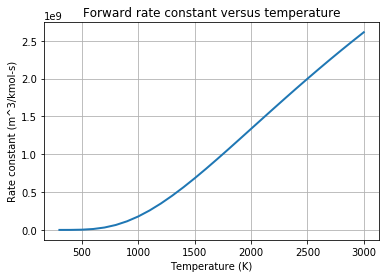

In [42]:
tmin = gas1.min_temp
tmax = gas1.max_temp + 1.
tinc = 100.
temp = np.arange(tmin,tmax,tinc)
nt   = len(temp)
kf2  = np.zeros(nt)

for i , T in enumerate(temp):
    gas1.TP  = T , None                         # set gas1 temperature; pressure and composition don't matter here
    kf2[i]   = gas1.forward_rate_constants[28]  # forward rate constant for reaction index 28
    
fig, ax = plt.subplots()
ax.plot(temp, kf2, lw=2)
ax.set(xlabel='Temperature (K)',
       ylabel='Rate constant (m^3/kmol-s)',
       title ='Forward rate constant versus temperature')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("kf_vs_T_28.pdf")

Note the "knee" in the curve at a temperature of approximately 1000 K. This is a characteristic of the rate constant (or rate coefficient) for a reaction that has an Arrhenius temperature dependance. The temperature at which the knee occurs is proportional to (but not equal to) the *activation temperature* for the reaction $T_A$, where $T_A \equiv E_A/R_u$. For example, for a reaction that has a higher activation energy value (still with b=0):

In [43]:
# access reaction index 30
r30 = gas1.reaction(30)

r30 , r30.rate

(<ElementaryReaction: CO + O2 <=> CO2 + O>,
 Arrhenius(A=2.5e+09, b=0, E=1.99995e+08))

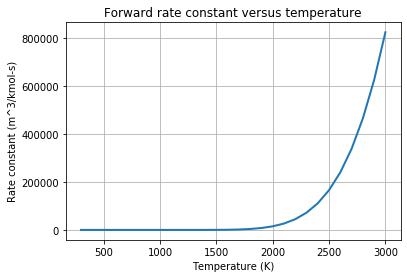

In [44]:
tmin = gas1.min_temp
tmax = gas1.max_temp + 1.
tinc = 100.
temp = np.arange(tmin,tmax,tinc)
nt   = len(temp)
kf2  = np.zeros(nt)

for i , T in enumerate(temp):
    gas1.TP  = T , None                         # set gas1 temperature; pressure and composition don't matter here
    kf2[i]   = gas1.forward_rate_constants[30]  # forward rate constant for reaction index 30
    
fig, ax = plt.subplots()
ax.plot(temp, kf2, lw=2)
ax.set(xlabel='Temperature (K)',
       ylabel='Rate constant (m^3/kmol-s)',
       title ='Forward rate constant versus temperature')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("kf_vs_T_30.pdf")

In can be seen that the temperature at which the rate coefficient begins to increase rapidly with increasing temperature is shifted to a higher temperature for a reaction that has a higher activation energy. The higher the activation energy (or equivalently, the higher the activation temperature) for a reaction, the higher the temperature must be for that reaction to become "activated". 

In most cases, the value of the activation energy $E_A$ for an individual reaction is zero or positive, although there are a few reactions in GRI-Mech 3.0 that have negative values of $E_A$. The value of the temperature exponent $b$ can be negative, zero, or positive. Thus the temperature dependence of the rate constant can vary widely from one reaction to another in a reaction mechanism. In particular, for $b = E_A = 0$, the rate constant is indeed a constant, and is independent of temperature. 

## 6. Three-body reactions

We consider reaction index 0 as an example of a three-body reaction with a generic third-body collision partner "M":

In [45]:
# access the reaction with reaction index 0 in the current mechanism as "r0"
r0 = gas1.reaction(0)
r0

<ThreeBodyReaction: 2 O + M <=> O2 + M>

Here M is a generic third-body collision partner, which can be any of the `n_species` species in the gas mixture. Three-body reactions are described in Chapter 4 of Turns 4th ed., and information on their treatment in Cantera can be found at http://cantera.github.io/docs/sphinx/html/cti/reactions.html. A brief explanation is provided here.

In a three-body reaction involving a generic third collision partner species M, M can be any of the `n_species` species or molecules in the gas mixture. Thus one can think of a three-body reaction of this kind as representing `n_species` distinct elementary reactions, one for each third-body species M. The reaction rate can be different for each third-body species M, and that is handled by introducing an *efficiency* value for each M. For each third-body species M, the base rate constant $k_f(T)$ for the forward reaction (given in the usual modified Arrhenius form) is multiplied by the efficiency value for that M, and the contributions are summed over all `n_species` third-body species to get the total contribution from the reaction. Note that the Cantera units of $k_f(T)$ for a three-body reaction are (kmol/m^3)^(-2)/s or m^6/kmol^2-s. 

To make this more clear, consider a gas mixture that contains $N_{spec}$ different chemical species or molecules, and a three-body reaction of the form $A + B + M \rightarrow C + M$, where $A$, $B$, and $C$ denote three species in the gas mixture and $M$ is a generic third body. The third-body efficiency for species $i$ is denoted as $ \eta _ {i} $. The time-rate-of-change of molar concentration of species $A$ by this reaction for a single third-body species $i$ is then:

$$ \frac{d[A]}{dt} \vert _ i = [A] [B] [M_i] \eta _ i k_f(T) $$

where $[M_i]$ is the molar concentration of species $i$. The time-rate-of-change of molar concentration of species $A$ considering all $N_{spec}$ third-body species is obtained by summing over all values of $i$:

$$ \frac{d[A]}{dt} = \sum _ {i=1} ^ {N_{spec}} \bigl( [A] [B] [M_i] \eta _ i k_f(T) \bigr) 
                   = [A] [B] k_f(T) \sum _ {i=1} ^ {N_{spec}} \bigl( \eta_i [M_i] \bigr)
                   = [A] [B] [M'] k_f(T) $$
                   
where

$$ [M'] \equiv \sum _ {i=1} ^ {N_{spec}} \bigl( \eta _ i [M_i] \bigr) $$

In the case where $ \eta_{i} = 1.0 $ for all $i$, $[M']$ is simply the total mixture molar concentration (kmol/m^3) for the gas mixture. The total mixture molar concentration is equal to the sum of the molar concentrations of all species in the mixture.

For the third-body reactions in most reaction mechanisms, values of $ \eta_i $ are provided explicitly for only a small subset of the $N_{spec}$ species in the mixture. A default efficiency value (denoted as $\eta_{def}$) is then used for all other species, where usually $\eta_{def} = 1.0 $.

Now, let's look at how third-body reactions are handled in Cantera, starting with the attributes of reaction r0:

In [46]:
# display all attributes of r0
dir(r0)

['ID',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'allow_negative_orders',
 'allow_negative_pre_exponential_factor',
 'allow_nonreactant_orders',
 'default_efficiency',
 'duplicate',
 'efficiencies',
 'efficiency',
 'equation',
 'fromCti',
 'fromXml',
 'listFromCti',
 'listFromFile',
 'listFromXml',
 'orders',
 'product_string',
 'products',
 'rate',
 'reactant_string',
 'reactants',
 'reaction_type',
 'reversible']

Reaction r0 has some attributes that were not available for reaction r2 (see Section 5 above). In particular, [`default_efficiency`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.ThreeBodyReaction.default_efficiency), [`efficiencies`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.ThreeBodyReaction.efficiencies), and [`efficiency()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.ThreeBodyReaction.efficiency) are related to third-body efficiencies. Let's look at those attributes, starting with the default third-body efficiency:

In [47]:
# get help for attribute "default_efficiency"
help(r0.__class__.default_efficiency)

Help on getset descriptor cantera._cantera.ThreeBodyReaction.default_efficiency:

default_efficiency
    Get/Set the default third-body efficiency for this reaction, used for
    species used for species not in `efficiencies`.



This is the default third-body efficiency, denoted as $ \eta _ {def} $ above.

In [48]:
# print the default third-body efficiency for reaction r0
r0.default_efficiency

1.0

The default efficiency is equal to 1.0. This is often the case.

Now let's look at how the non-default species-specific efficiency values are specified:

In [49]:
# get help for attribute "efficiencies"
help(r0.__class__.efficiencies)

Help on getset descriptor cantera._cantera.ThreeBodyReaction.efficiencies:

efficiencies
    Get/Set a `dict` defining non-default third-body efficiencies for this
    reaction, where the keys are the species names and the values are the
    efficiencies.



In [50]:
# print the non-default species-specific third-body efficiencies for reaction r0
r0.efficiencies

{'AR': 0.83,
 'C2H6': 3.0,
 'CH4': 2.0,
 'CO': 1.75,
 'CO2': 3.6,
 'H2': 2.4,
 'H2O': 15.4}

For reaction r0, non-default efficiency values are given for only seven of the 53 species in gri30.cti. For any species $i$ that is not listed here, $\eta_i = \eta_{def} = 1.0 $.

It can be seen that a water molecule is especially effective as a third-body collision partner for this particular reaction.

Note that argon ('AR') is one of the species included in the reaction mechanism. Argon is often included for cases where it is desirable to have an inert diluent that does not participate chemically. In fact, the only way that AR appears in the mechanism is as a third-body ('M') in the three-body reactions. This can be verified by scanning through the mechanism and looking for 'AR'.

Before proceeding, we make a brief detour to introduce Python dictionary ('dict') objects.

### 6.1 A brief detour: 'dict' objects

The help output for `efficiencies` above states that it is a 'dict' object: that is, it is a Python dictionary. Several online tutorials are available for Python dictionaries, and the interested reader is referred there for more information. A few key points are made here that are relevant for our current purposes, and that will be useful in subsequent tutorial Notebooks.

A dictionary is a collection of key:value pairs. In the case of `efficiencies`, the key is a species name and the value is the third-body efficiency for that species. We have seen this construction in earlier tutorial Notebooks, where it has been used to specify the composition of a gas mixture, for example.

The following examples illustrate some basic operations that can be performed using a dictionary object.

In [51]:
# create and print an array that contains the keys in "efficiencies"
array = list(r0.efficiencies)
array

['AR', 'C2H6', 'CH4', 'CO', 'CO2', 'H2', 'H2O']

In [52]:
# access and print the value corresponding to a specified key (here 'C2H6')
eta = r0.efficiencies['C2H6']
eta

3.0

In [53]:
 # loop over the items in a 'dict' and print the key and the value for each
for item in r0.efficiencies:
    print(item)
    print(r0.efficiencies.get(item))

AR
0.83
C2H6
3.0
CH4
2.0
CO
1.75
CO2
3.6
H2
2.4
H2O
15.4


In [54]:
# compute and print the third-body-efficiency-weighted sum of the molar concentrations of the species for which non-default
#   efficiency values are given
sum = 0.
for item in r0.efficiencies:
    sum += r0.efficiencies.get(item)*gas1.concentrations[gas1.species_index(item)]

sum

0.009749277707333553

### 6.2 Back to three-body reactions

The function `efficiency()` accesses the third-body efficiency for each species in the gas mixture, and takes a species name as its argument. For each species that is listed in `efficiencies`, this is the value given there. For each species that is not listed in `efficiencies`, this is the value given by `default_efficiency`. 

In [55]:
# get help for attribute "efficiency"
help(r0.__class__.efficiency)

Help on method_descriptor:

efficiency(...)
    ThreeBodyReaction.efficiency(self, species)
    
    Get the efficiency of the third body named *species* considering both
    the default efficiency and species-specific efficiencies.



In [56]:
# print the third-body efficiency factor for CO2 in reaction r0
r0.efficiency('CO2')

3.6

This is consistent with the CO2 value reported by `efficiencies`. For a species that is not on the `efficiencies` list, the default value given by `default_efficiency` is used. For example:

In [57]:
# print the third-body efficiency factor for N2 in reaction r0
r0.efficiency('N2')

1.0

This is the default efficiency value.

Now let's look at the modified Arrhenius rate parameters for three-body reaction r0:

In [58]:
r0.rate

Arrhenius(A=1.2e+11, b=-1, E=0)

Before proceeding, we reset the composition of the gas mixture to something other than the default composition (pure H2, the first species in the list of species). For reasons that we will see shortly, we want to have non-zero values of molar concentrations of more than one species. For that purpose, we (somewhat arbitrarily) set the composition to equal mass fractions of all species:

In [59]:
Y        = np.ones(gas1.n_species)
gas1.TPY = 1000., ct.one_atm, Y

gas1()


  gri30:

       temperature            1000  K
          pressure          101325  Pa
           density        0.185332  kg/m^3
  mean mol. weight         15.2079  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy       1.196e+07        1.819e+08     J
   internal energy      1.1413e+07        1.736e+08     J
           entropy           15750        2.395e+05     J/K
    Gibbs function     -3.7902e+06       -5.764e+07     J
 heat capacity c_p          2770.1        4.213e+04     J/K
 heat capacity c_v          2223.3        3.381e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2        0.14234        0.0188679         -19.4551
                 H       0.284681        0.0188679          9.89457
                 O      0.0179345        0.0188679          5.26947
                O2     0.0

Now, let's compare the value of $k_f(T)$ computed using the modified Arrhenius rate coefficients with the value reported by `forward_rate_constants` for reaction r0:

In [60]:
# compute the forward rate constant using the modified Arrhenius coefficients and the current temperature
R_u = ct.gas_constant # universal gas constant (J/kmol-K)
A0  = 1.2e+11         # pre-exponential factor (kmol/m^3)^(-2)/s, since r0 is a three-body reaction in forward direction
b0  = -1.             # temperature exponent (dimensionless)
E0  = 0.              # activation energy (J/kmol)
T   = gas1.T          # temperature (K)

k_f0 = A0*T**b0*np.exp(-E0/(R_u*T)) # the exponential function is defined in numpy
k_f0

120000000.0

In [61]:
gas1.forward_rate_constants[0]

2177530.0753192254

The values are not the same! 

The reason for this is that for a three-body reaction, the value reported by `forward_rate_constants` includes the quantity that was defined earlier as $[M']$. That is, `forward_rate_constants` contains the value $[M']k_f(T)$. This is confirmed as follows. Recall that attribute `concentrations` is an array that contains the molar concentrations of all species in the gas mixture.

In [62]:
# compute the third-body-efficiency-weighted sum of the molar concentrations of all species in the gas mixture
Mprime = 0.
for i in range(gas1.n_species):
    Mprime += r0.efficiency(gas1.species_name(i))*gas1.concentrations[i]
    
k_f0*Mprime

2177530.0753192236

This confirms that `forward_rate_constants` includes $[M']$ for a three-body reaction. Thus the value depends on the composition of the gas mixture, in addition to the temperature.

Note that $[M']k_f(T)$ has units of m^3/kmol-s, the same as the units of a rate constant for a bimolecular reaction.

The reason that `forward_rate_constants` includes $[M']$ has to do with the way that reactions are handled internally in Cantera, and is beyond the scope of the current discussion. For most purposes, users will not need to concern themselves with these subtleties.

Before proceeding, we make another observation. The gas mixture named "gas1" and the reaction named "r0" both have a `reactants` attribute, but the attributes are not quite the same:

In [63]:
# get help for gas1 attribute "reactants"
help(gas1.__class__.reactants)

Help on method_descriptor:

reactants(...)
    Kinetics.reactants(self, int i_reaction)
    The reactants portion of the reaction equation



As we saw earlier, this is a function that takes a reaction index as its argument and returns the left-hand side (reactants side) of the corresponding reaction equation.

In [64]:
# get help for r0 attribute "reactants"
help(r0.__class__.reactants)

Help on getset descriptor cantera._cantera.Reaction.reactants:

reactants
    Get/Set the reactants in this reaction as a dict where the keys are
    species names and the values, are the stoichiometric coefficients, e.g.
    ``{'CH4':1, 'OH':1}``, or as a composition string, e.g.
    ``'CH4:1, OH:1'``.



This is a dictionary object for an individual reaction, not a function.

The values reported by `gas1.reactants(0)` and `r0.reactants` are not the same:

In [65]:
# print the left-hand side (reactants side) of reaction index 0
gas1.reactants(0)

'2 O + M'

In [66]:
# print r0.reactants
r0.reactants

{'O': 2.0}

In particular, note that the third-body 'M' is not included in "r0.reactants" while 'M' is included in "gas1.reactants(0)". The same is true for "gas1.products(0)" versus "r0.products". 

## 7. Exothermic and endothermic reactions

For each reaction, the difference between the products-side (right-hand-side) enthalpy and reactants-side (left-hand-side) enthalpy is the enthalpy change associated with the reaction. For a reaction involving ideal gases, this value depends only on the species involved in the reaction, their stoichiometric coefficients, and the current mixture temperature. The relevant attribute is [`delta_enthalpy`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.delta_enthalpy), as we saw earlier in tutorial Notebook 2.7_Entropy-Gibbs_function-equilibrium_constants:

In [67]:
help(gas1.__class__.delta_enthalpy)

Help on getset descriptor cantera._cantera.Kinetics.delta_enthalpy:

delta_enthalpy
    Change in enthalpy for each reaction [J/kmol].



A negative value of `delta_enthalpy` corresponds to a reaction that is exothermic in the forward direction and endothermic in the reverse direction. A positive value corresponds to a reaction that is endothermic in the forward direction and exothermic in the reverse direction.

In [68]:
# print the enthalpy change for all 325 reactions at the current mixture temperature
gas1.delta_enthalpy

array([-5.05356933e+08, -4.36352177e+08,  8.13316089e+06, -2.23165213e+08,
       -6.36380617e+07, -7.38842706e+08, -3.80541139e+08, -7.89255861e+08,
       -4.17253483e+08, -2.86704311e+08,  1.36462993e+07, -5.35303140e+08,
       -3.63869217e+08, -4.62820180e+08, -5.87083912e+07, -3.08378437e+08,
       -3.36121821e+08, -2.04784982e+07,  7.26488587e+06, -3.33993321e+08,
       -8.00724326e+07,  1.26665553e+08, -2.01760119e+08, -3.73872154e+08,
       -1.14442561e+08, -3.33112876e+08, -7.57439479e+06, -4.29745865e+08,
        1.44671055e+07, -2.06171544e+08, -2.99462070e+07,  1.64456822e+08,
       -2.13186964e+08, -2.13186964e+08, -2.13186964e+08, -2.13186964e+08,
       -2.13186964e+08,  6.90047560e+07, -4.44485337e+08, -4.44485337e+08,
       -4.44485337e+08, -4.44485337e+08, -5.08673656e+08, -2.26481936e+08,
       -2.31298374e+08, -1.54160457e+08, -7.17712226e+07, -2.90119998e+08,
       -9.91815638e+07, -4.71480613e+08, -5.04131545e+07, -4.49998476e+08,
        5.51313843e+06, -

We will not go further with this here, since it was discussed in an earlier tutorial Notebook. It is included here for completeness.

## 8. Equilibrium constants and reverse reaction rates for elementary reactions

For an elementary reaction, the forward and reverse rates are not independent: they are related through an equilibrium constant, which can be computed using thermodynamic properties. As we saw earlier in Notebook 2_7_Entropy_Gibbs_function_equilibrium_constants, equilibrium constants for each reaction are available using the [`equilibrium_constants`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.equilibrium_constants) attribute. These are molar-concentration-based equilibrium constants $ \kappa _ c (T)$, as discussed there, so that the units are (kmol/m^3)^n, where n is the difference between the the number of moles (or molecules) on the right-hand side (products side) of the reaction minus the number of moles (or molecules) on the left-hand side (reactants side) of the reaction. The values of the equilibrium constants depend on the current mixture temperature and (for reactions where n is nonzero) pressure, but not on the current mixture composition.

In [69]:
help(gas1.__class__.equilibrium_constants)

Help on getset descriptor cantera._cantera.Kinetics.equilibrium_constants:

equilibrium_constants
    Equilibrium constants in concentration units for all reactions.



In [70]:
# access the equilbrium constant for reaction index 2 at the current mixture temperature
gas1.equilibrium_constants[2]

0.829130431758196

The reverse rate for an elementary reaction is equal to the forward rate divided by the value of the molar equilibrium constant: $ k _ r (T) = k _ f (T) / \kappa _ c (T)$. Reverse rate constants are available using attribute [`reverse_rate_constants`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.reverse_rate_constants). To verify that this relationship is satisfied:

In [71]:
# access the forward rate constant for reaction index 2 using "forward_rate_constants"
k_f2 = gas1.forward_rate_constants[2]
k_f2

208745085.15891254

In [72]:
# compute the reverse rate constant for reaction index 2 using the equilibrium constant
k_r2 = k_f2/gas1.equilibrium_constants[2]
k_r2

251763868.70309696

In [73]:
# access the reverse rate constant for reaction index 2 using "reverse_rate_constants"
gas1.reverse_rate_constants[2]

251763868.70309693

This confirms that the forward and reverse rate constants are thermodynamically consistent for an elementary reaction. This is also the case for three-body reactions, although again, there are subtleties related to how such reactions are handled internally in Cantera.  

## 9. Forward, reverse, and net rates of reaction progress

Here we continue to use reaction index 2 as an example.

In [74]:
# access reaction index 2 as r2
r2 = gas1.reaction(2)
r2

<ElementaryReaction: H2 + O <=> H + OH>

The forward rate of progress for a reaction is the product of the forward rate constant for the reaction $k_f(T)$ times the products of the molar concentrations of each left-hand-side species, each raised to a power that is equal to its reaction order in the forward reaction. For an elementary reaction, the reaction order for each species is equal to its stoichiometric coefficient in the reactants. The forward rate of progress for each reaction is accessed using attribute [`forward_rates_of_progress`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.forward_rates_of_progress), which is an array:

In [75]:
# get help for attribute "forward_rates_of_progress"
help(gas1.__class__.forward_rates_of_progress)

Help on getset descriptor cantera._cantera.Kinetics.forward_rates_of_progress:

forward_rates_of_progress
    Forward rates of progress for the reactions. [kmol/m^3/s] for bulk
    phases or [kmol/m^2/s] for surface phases.



Similarly, the reverse rate of progress for a reaction is the product of the reverse rate constant for the reaction $k_r(T)$ times the products of the molar concentrations of each right-hand-side species, each raised to a power that is equal to its reaction order (or stoichiometric coefficient) in the reverse reaction. The reverse rate of progress for each reaction is accessed using attribute [`reverse_rates_of_progress`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.reverse_rates_of_progress), which is an array:

In [76]:
# get help for attribute "reverse_rates_of_progress"
help(gas1.__class__.reverse_rates_of_progress)

Help on getset descriptor cantera._cantera.Kinetics.reverse_rates_of_progress:

reverse_rates_of_progress
    Reverse rates of progress for the reactions. [kmol/m^3/s] for bulk
    phases or [kmol/m^2/s] for surface phases.



For example, for reaction index 2, the forward rate of progress is $ k_{f2} (T) [{\rm H}_2] [{\rm O}]$ and the reverse rate of progress is $k_{r2}(T) [{\rm H}] [{\rm OH}]$, where the square brackets denote molar concentrations in kmol/m^3.

In [77]:
# print the forward and reverse rates of progress for reaction index 2
gas1.forward_rates_of_progress[2] , gas1.reverse_rates_of_progress[2]

(79.14045468097888, 179.58620937400326)

For the current gas mixture state, the reverse rate of progress is greater than the forward rate of progress.

In [78]:
# get the molar concentrations (kmol/m^3) of the four species involved in reaction r2
C_H2 = gas1.concentrations[gas1.species_index('H2')]
C_O  = gas1.concentrations[gas1.species_index('O')]
C_H  = gas1.concentrations[gas1.species_index('H')]
C_OH = gas1.concentrations[gas1.species_index('OH')]

C_H2 , C_O , C_H , C_OH

(0.0017346451698167298,
 0.00021856047757604346,
 0.0034692903396334597,
 0.0002056074909380391)

We then confirm that the forward and reverse rates of progress for reaction r2 are consistent with the forward and reverse rate constants and the molar concentrations:

In [79]:
# compute the forward rate of progress of reaction index 2 using molar concentrations
#   and attribute "forward_rate_constants"
forward = C_H2*C_O*gas1.forward_rate_constants[2]
forward

79.14045468097888

In [80]:
# access the forward rate of progress of reaction index 2 using attribute "forward_rates_of_progress"
gas1.forward_rates_of_progress[2]

79.14045468097888

In [81]:
# compute the reverse rate of progress of reaction index 2 using molar concentrations
#   and attribute "reverse_rate_constants"
reverse = C_H*C_OH*gas1.reverse_rate_constants[2]
reverse

179.58620937400326

In [82]:
# access the reverse rate of progress of reaction index 2 using attribute "reverse_rates_of_progress"
gas1.reverse_rates_of_progress[2]

179.58620937400326

Then the attribute [`net_rates_of_progress`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.net_rates_of_progress) gives the difference between the forward rate of progress and the reverse rate of progress for each reaction. This is the quantity denoted as $ q_i $ (for reaction $i$) in Chapter 4 of Turns 4th ed.

In [83]:
# get help for attribute "net_rates_of_progress"
help(gas1.__class__.net_rates_of_progress)

Help on getset descriptor cantera._cantera.Kinetics.net_rates_of_progress:

net_rates_of_progress
    Net rates of progress for the reactions. [kmol/m^3/s] for bulk phases
    or [kmol/m^2/s] for surface phases.



In [84]:
# access the net rate of progress for reaction index 2
gas1.net_rates_of_progress[2]

-100.44575469302438

Here the net rate of progress is negative, because the reverse rate of progress exceeds the forward rate of progress.

When the mixture is in chemical equilibrium, the forward and reverse rates of progress for each reaction are not equal to zero, but the net rate of progress for each reaction is equal to zero. We can confirm this by setting the composition of gas1 to correspond to the equilbrium composition:

In [85]:
# reset the composition of gas1 to the equilbrium composition, keeping the mixture temperature and pressure constant
gas1.equilibrate('TP')
gas1()


  gri30:

       temperature            1000  K
          pressure          101325  Pa
           density        0.194252  kg/m^3
  mean mol. weight         15.9398  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -1.5103e+06       -2.407e+07     J
   internal energy     -2.0319e+06       -3.239e+07     J
           entropy           14007        2.233e+05     J/K
    Gibbs function     -1.5518e+07       -2.473e+08     J
 heat capacity c_p          2589.2        4.127e+04     J/K
 heat capacity c_v          2067.6        3.296e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2       0.363013        0.0459096         -18.5189
                 H    1.36736e-09      8.64638e-11         -9.25943
                OH     1.8236e-14      1.94573e-14          -50.814
               H2O     0.0

In [86]:
# print the forward, reverse, and net rates of progress for reaction r2
gas1.forward_rates_of_progress[2] , gas1.reverse_rates_of_progress[2], gas1.net_rates_of_progress[2]

(9.323317718446325e-19, 9.323317718446344e-19, -1.925929944387236e-33)

In fact, the individual forward and reverse rates of progress for this particular reaction are quite small when the mixture is in equilibrium, because the equilibrium molar concentrations of the four participating species are small.

In equilibrium, the net rates of progress are equal to zero for all 325 reactions:

In [87]:
gas1.net_rates_of_progress

array([-1.21074985e-56, -7.39885589e-43, -1.92592994e-33,  0.00000000e+00,
        2.95677859e-55, -7.83036536e-54, -2.32637440e-46, -1.73729706e-49,
       -2.29857765e-49,  1.46936794e-39,  0.00000000e+00, -2.48264407e-35,
        1.43492963e-42,  1.43492963e-42, -5.51012977e-38,  8.75811540e-47,
       -1.71056941e-49,  1.14794370e-41,  5.73971851e-42, -3.80868971e-50,
       -6.31828214e-38,  7.17464814e-42, -3.23260946e-38,  2.24207754e-44,
       -3.76158192e-36,  4.30478888e-42,  3.76158192e-37,  9.63392694e-46,
       -2.06629866e-40, -6.65807347e-40, -5.25486924e-45, -1.04344734e-47,
       -1.68155816e-44, -3.18759904e-69, -3.61272260e-46, -1.57646077e-45,
       -6.02120434e-47, -5.60519386e-45, -2.36658272e-30, -1.38050658e-30,
       -6.16297582e-32, -3.62074830e-32,  3.27408091e-33,  6.78753944e-46,
        6.13068078e-45,  7.70714155e-45,  3.22859166e-42,  1.57842259e-41,
        3.44383111e-41, -1.08333559e-34,  1.22251412e-36, -1.03397577e-25,
        3.89635156e-20,  

The net rates of progress are all equal to zero, to machine precision, as they should be for a system that is in chemical equilibrium.

Here we computed the equilbrium for a given mixture temperature and pressure. The key result (that the net rates of progress are equal to zero for all reactions) would be the same regardless of which two mixture thermodynamic properties were held constant during the equilibrium calculation.

## 10. Net rates of species production

Finally, we arrive at the net production rate for each species in the system. For species $i$, this quantity is denoted as $ \dot \omega _ i $ in Chapter 4 of Turns 4th ed., and has units of kmol/m^3-s (molar concentration per time). This is simply the sum over all of the reactions of the contribution of each reaction to the net production of species $i$. The relevant attribute is [`net_production_rates`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.net_production_rates), which is an array that contains `n_species` values of $ \dot \omega _ i $:

In [88]:
# get help for attribution "net_production_rates"
help(gas1.__class__.net_production_rates)

Help on getset descriptor cantera._cantera.Kinetics.net_production_rates:

net_production_rates
    Net production rates for each species. [kmol/m^3/s] for bulk phases or
    [kmol/m^2/s] for surface phases.



Here we are considering "bulk phases" (gas-phase volumetric reactions) rather than "surface phases". The latter would be appropriate for catalyic and heterogeneous reactions.

Since the current thermochemical state of gas1 corresponds to chemical equilibrium, the net production rates for all 53 species are equal to zero (to machine precision):

In [89]:
# access the net species production rates
gas1.net_production_rates

array([ 1.17143547e-12, -1.17139314e-12, -6.26822308e-24, -2.10155645e-35,
       -7.84678495e-17,  3.61437184e-17, -5.89368947e-34,  5.90186540e-34,
        3.45826765e-41,  1.47292270e-32, -1.04077866e-27, -1.76351064e-17,
        1.17142223e-12,  1.95262926e-13,  1.36670985e-12,  7.49639899e-25,
        1.15363224e-22,  4.23241315e-17,  2.12978838e-27,  3.96782783e-28,
       -7.48740990e-28,  2.45209403e-29, -2.01868123e-26,  3.44299345e-24,
       -1.62957971e-23,  1.86070200e-23, -6.82585555e-24, -1.13095668e-26,
        7.88361654e-26, -4.42963887e-33,  1.11933693e-35,  9.17486275e-31,
        2.40747668e-24, -2.38001228e-24,  1.49926490e-24, -1.80043720e-36,
        7.67030087e-47,  8.43833913e-41, -4.12159237e-32,  6.46688459e-27,
       -7.30248267e-25,  7.23783036e-25, -2.35100305e-36, -8.66640042e-41,
       -1.72563323e-31, -2.76686850e-26,  2.01934925e-28, -1.49926490e-24,
        6.02120434e-47, -3.38079000e-25, -2.93662532e-26, -6.58425502e-26,
       -1.36670985e-12])

## 11. What's next

In subsequent tutorials, we will use the quantities introduced here to explore various aspects of chemical kinetics and to solve various combustion problems. In most cases, we will not need to dig deeply into the "raw" attributes that have been discussed here, or to understand the nuances of how three-body reactions (for example) are treated internally.